In [43]:
import pymc as pm
import numpy as np
%matplotlib inline
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
import math
import scipy.stats
from statsmodels.stats import weightstats
import matplotlib.mlab as mlab

In [44]:
# plot the normal distribution
def plot_gaus(z, p):
    gaus = {
        'mean': 0,
        'variance': 1,
        'width': 4
    }
    if abs(z) > 3:
        gaus['width'] = 6
    else:
        gaus['width'] = 4


    # plotting the chart
    x = np.linspace(-gaus['width'],gaus['width'],100)
    plt.title = str(p)
    plt.plot(x, mlab.normpdf(x,gaus['mean'], gaus['variance']**0.5)) # plots a standard guasian plot
    plt.plot((z, z), (0, 0.4), 'k-') # plots a vertical line where our z score comes, 0.4 is the height of the chart
    plt.fill_between(x=x, 
                     y1=mlab.normpdf(x,gaus['mean'], gaus['variance']**0.5), 
                     interpolate=True,
                     where=abs(x)>abs(z),
                     alpha=0.5)
    print "p value = %.5f" % p
    plt.show()

In [21]:
## transfer some data into a form we can work with
class Sample:
    def __init__(self, samples, mean):
        self.samples = samples
        self.mean = mean
        self.successes = int(round(samples * mean))
        self.failures = int(round(samples * (1-mean)))
        self.observations = np.array([0]*self.failures + [1]*self.successes)
        np.random.shuffle(self.observations)
        
    @classmethod
    def from_success_failure(self, successes, failures):
        self.samples = successes + failures
        self.successes = successes
        self.failures = failures
        self.observations = np.array([0]*self.failures + [1]*self.successes)
        np.random.shuffle(self.observations) # inplace
        self.mean = np.mean(self.observations)
        
control = Sample(163435, 0.1151)
caption_overlay = Sample(162437, 0.1182)
caption_larger_text = Sample(162256, 0.1161)

In [23]:
# Set up the pymc model. Again assume Uniform priors for p_A and p_B.
p_A = pm.Uniform("p_A", 0, 1)
p_B = pm.Uniform("p_B", 0, 1)


# Define the deterministic delta function. This is our unknown of interest.
@pm.deterministic
def delta(p_A=p_A, p_B=p_B):
    return p_A - p_B

# Set of observations, in this case we have two observation datasets.
obs_A = pm.Bernoulli("obs_A", p_A, value=control.observations, observed=True)
obs_B = pm.Bernoulli("obs_B", p_B, value=caption_overlay.observations, observed=True)

mcmc = pm.MCMC([p_A, p_B, delta, obs_A, obs_B])
mcmc.sample(20000, 1000)

 [-----------------100%-----------------] 20000 of 20000 complete in 652.7 sec

In [24]:
p_A_samples = mcmc.trace("p_A")[:]
p_B_samples = mcmc.trace("p_B")[:]
delta_samples = mcmc.trace("delta")[:]

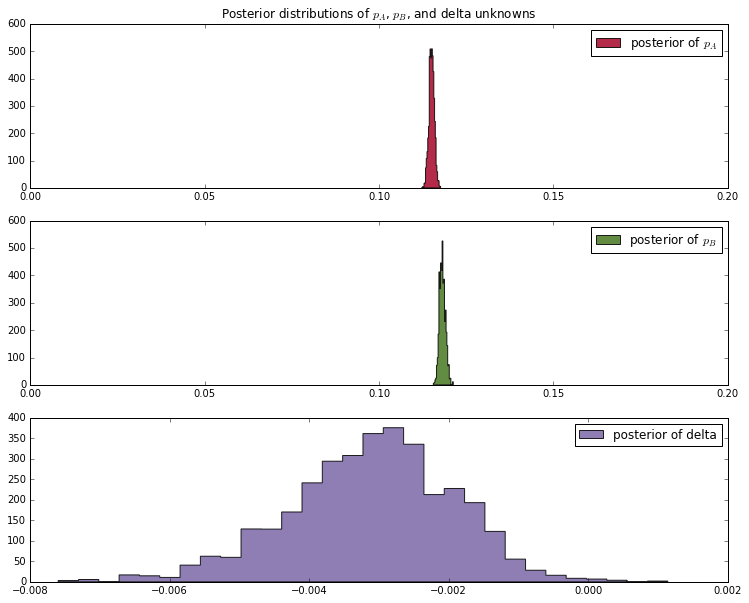

In [28]:
figsize(12.5, 10)

# histogram of posteriors

ax = plt.subplot(311)

plt.xlim(0, 0.2)
plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_A$", color="#A60628", normed=True)
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

ax = plt.subplot(312)

plt.xlim(0, 0.2)
plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_B$", color="#467821", normed=True)
# plt.vlines(true_p_B, 0, 80, linestyle="--", label="true $p_B$ (unknown)")
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color="#7A68A6", normed=True)
# plt.vlines(true_p_A - true_p_B, 0, 60, linestyle="--",
#            label="true delta (unknown)")
# plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.legend(loc="upper right");

In [29]:
# Count the number of samples less than 0, i.e. the area under the curve
# before 0, represent the probability that site A is worse than site B.
print "Probability site A is WORSE than site B: %.3f" % \
    (delta_samples < 0).mean()

print "Probability site A is BETTER than site B: %.3f" % \
    (delta_samples > 0).mean()

Probability site A is WORSE than site B: 0.996
Probability site A is BETTER than site B: 0.004


In [30]:
# Or for frequentist statistics, written out long hand for clarity of what we're doing
muV1 = caption_overlay.observations.mean()
muV2 = caption_larger_text.observations.mean()
muC = control.observations.mean()
SEV1 = muV1 * (1-muV1) / math.sqrt(len(caption_overlay.observations))
SEV2 = muV2 * (1-muV2) / math.sqrt(len(caption_larger_text.observations))
SEC = muC * (1-muC) / math.sqrt(len(control.observations))
z1 = (muV1 - muC) / (SEV1**2 + SEC**2)**0.5
z2 = (muV2 - muC) / (SEV2**2 + SEC**2)**0.5

p1 = scipy.stats.norm.sf(abs(z1))*2 #twosided
p2 = scipy.stats.norm.sf(abs(z2))*2 #twosided

p value = 0.00000


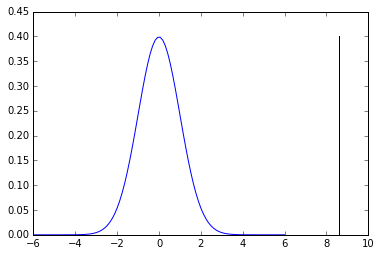

In [45]:
plot_gaus(z1, p1)

p value = 0.00513


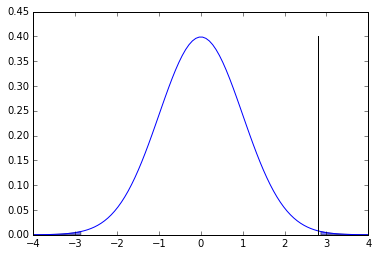

In [46]:
plot_gaus(z2, p2)

In [49]:
delta1alt, p1alt = weightstats.ztest(control.observations, caption_larger_text.observations)
print delta1alt, p1alt

-0.894865565642 0.370858956066
